In [1]:
from os.path import join
import warnings
import time
from selenium import webdriver
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text
from wordcloud import WordCloud
from sklearn.cluster import MiniBatchKMeans
import numpy as np
import umap

warnings.filterwarnings('ignore') 
plt.style.use('seaborn-poster')

In [2]:
DIR_DATA = '../data'
DIR_CSV = join(DIR_DATA, 'liga_stupid_nlp_output.csv')
DIR_CLEAN_CSV = join(DIR_DATA, 'liga_stupid_nlp.csv')

# Functions

In [3]:
def page_parser(driver, path_output):
    """Extract infomation from 1 page of Pikabu.ru with Selenium driver. Save to csv file.
    Columns: 'data_id', 'user', 'rating', 'date', 'title', 'content', 'tags', 'link'.
    """
    dict_stories = {}
    for story in driver.find_elements_by_class_name('story'):
        dict_page = {}
        if len(story.text) != 0:
            if (story.find_element_by_class_name('user__nick').text != 'specials'):
                dict_page['user'] = story.find_element_by_class_name('user__nick').text
                dict_page['rating'] = story.find_element_by_class_name('story__rating-count').text
                dict_page['date'] = story.find_element_by_tag_name('time').get_attribute('datetime')
                dict_page['title'] = story.find_element_by_class_name('story__title').text
                dict_page['content'] = story.find_element_by_class_name('story__content-inner').text
                dict_page['tags'] = story.find_element_by_class_name('tags').text
                dict_page['link'] = story.find_element_by_class_name('story__title').find_element_by_tag_name('a').get_attribute('href')
                data_id = story.get_attribute('data-story-id')
                dict_stories[data_id] = dict_page
    df = pd.DataFrame.from_dict(dict_stories, orient='index')
    df.to_csv(path_output, header=False, mode = 'a')


class USEEncoder(object):
    """Generate embeddings from text with Universal Sentence Encoder."""
    
    def __init__(self, batch_size, text_column):
        """
        Parameters
        ----------
        batch_size : int
           Size of a batch.
        text_column : str
           Name of a text column in the dataframe.
        
        """
        self._batch_size = batch_size
        self._text_column = text_column

    def transform(self, df, use_model):
        """Short summary.

        Parameters
        ----------
        df : pandas dataframe
            DataFrame with a text column.
        use_model : TF model
            Pretrained Universal Sentence Encoder model.

        Returns
        -------
        numpy array
            Embeddings generated from text.
        """
        batch_range = np.arange(1, df.shape[0], self._batch_size)
        start_last_batch = batch_range[-1]
        end_last_batch = df.shape[0]+1
        batch_range = np.delete(batch_range, -1)

        # Generate embedding of the first row for array initialization.
        embeddings = use_model(df[self._text_column].values[0])
        for batch in tqdm(batch_range):
            embedding = use_model(df[self._text_column].values[batch:batch+self._batch_size])
            embeddings = np.vstack((embeddings, embedding))
        # Generate embeddings for the last batch.
        embedding = use_model(df[self._text_column].values[start_last_batch:end_last_batch])
        embeddings = np.vstack((embeddings, embedding))

        return embeddings
    
def calculate_number_clusters(data, max_k):
    """Calculate optimal number of clusters.
    """
    iters = range(2, max_k + 1, 2)
    sse = []
    for k in tqdm(iters):
        cls = MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data)
        sse.append(cls.inertia_)
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    plt.show()

def clustering(data, n_clusters):
    """Clastering with MiniBatchKMeans.
    """
    clusters = MiniBatchKMeans(n_clusters=n_clusters,
                               init_size=1024,
                               batch_size=2048,
                               random_state=20).fit_predict(data)
    return clusters

# Parser

In [4]:
link = 'https://pikabu.ru/community/Liga_stupid/new?page={}'
driver = webdriver.Firefox()

In [ ]:
for page in tqdm(range(0, 301)):
    driver.get(link.format(page))
    page_parser(driver, DIR_CSV)

# Cleaning Data

In [4]:
df = pd.read_csv(DIR_CSV, names=['data_id', 'user', 'rating', 'date', 'title', 'content', 'tags', 'link'])

In [5]:
# Drop duplicates
df = df.drop_duplicates(subset=['data_id'])
# Replace Nan
df.loc[df['rating'].isna(), 'rating'] = 0
df.loc[df['content'].isna(), 'content'] = '<IMG>'
# Set relevant types
df['rating'] = df['rating'].astype('int')
df['date'] = pd.to_datetime(df['date'])

In [6]:
df[df['date'] < '2021-06-02']

,data_id,user,rating,date,title,content,tags,link
3016,8248040,rokoman13,0,2021-06-01 15:54:38+03:00,Буксировка,<IMG>,[моё] Автомобилисты Юмор Буксировка Текст,https://pikabu.ru/story/buksirovka_8248040
3017,6997270,AlekseyMB,2352,2019-10-19 10:30:44+03:00,Сегодня я стал сказочным дол*ое*ом,"Поздравьте меня. Нет не просто долбоеб, а долб...",[моё] Пожарная безопасность Пожар Газовая коло...,https://pikabu.ru/story/segodnya_ya_stal_skazo...


In [7]:
# Delete anomalies
df = df[df['date'] > '2021-06-10']

In [8]:
df.head(2)

,data_id,user,rating,date,title,content,tags,link
0,8309299,Xodoorkovskiy,0,2021-06-28 19:40:06+03:00,Дело было на селе-Со слов сослуживца,"Короче, сказ будет со слов моего сослуживца.\n...",[моё] Тупость Воспоминания Деревня Секс Сам се...,https://pikabu.ru/story/delo_byilo_na_seleso_s...
1,8309276,Kohena,0,2021-06-28 19:25:37+03:00,Немножко забыла,Случилось на днях. Заказали всякую всячину из ...,[моё] Лига тупых Забывчивость Истории из жизни...,https://pikabu.ru/story/nemnozhko_zabyila_8309276


In [9]:
df.tail(2)

,data_id,user,rating,date,title,content,tags,link
3014,8284329,Indianaorc,8314,2021-06-18 15:45:37+03:00,Чо орать то?! Я не повар!,<IMG>,Тупость Скриншот Юмор Повар Повтор Родители и ...,https://pikabu.ru/story/cho_orat_to_ya_ne_pova...
3015,8284293,Yngwie,20,2021-06-18 15:31:09+03:00,Первый наX!,"ну, это... всем привет в этом чатике!",Тупость Тупые,https://pikabu.ru/story/pervyiy_nax_8284293


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2986 entries, 0 to 3015
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype                                
---  ------   --------------  -----                                
 0   data_id  2986 non-null   int64                                
 1   user     2986 non-null   object                               
 2   rating   2986 non-null   int64                                
 3   date     2986 non-null   datetime64[ns, pytz.FixedOffset(180)]
 4   title    2986 non-null   object                               
 5   content  2986 non-null   object                               
 6   tags     2986 non-null   object                               
 7   link     2986 non-null   object                               
dtypes: datetime64[ns, pytz.FixedOffset(180)](1), int64(2), object(5)
memory usage: 210.0+ KB


In [ ]:
# Save clean dataset
df.to_csv(DIR_CLEAN_CSV, index=False)

# Data Visualization

In [11]:
# Load clean data
df = pd.read_csv(DIR_CLEAN_CSV)
df['rating'] = df['rating'].astype('int')
df['date'] = pd.to_datetime(df['date'])

In [12]:
df_by_days = df[['date']]
df_by_days.loc[:,'updates'] = 1
df_by_days = df_by_days.resample('D', convention='end', label='left', on='date').sum()

In [13]:
df_by_days.sort_values('updates')

,updates
date,
2021-06-18 00:00:00+03:00,2
2021-06-19 00:00:00+03:00,4
2021-06-20 00:00:00+03:00,12
2021-06-21 00:00:00+03:00,60
2021-06-28 00:00:00+03:00,104
2021-06-27 00:00:00+03:00,117
2021-06-26 00:00:00+03:00,147
2021-06-25 00:00:00+03:00,340
2021-06-24 00:00:00+03:00,588


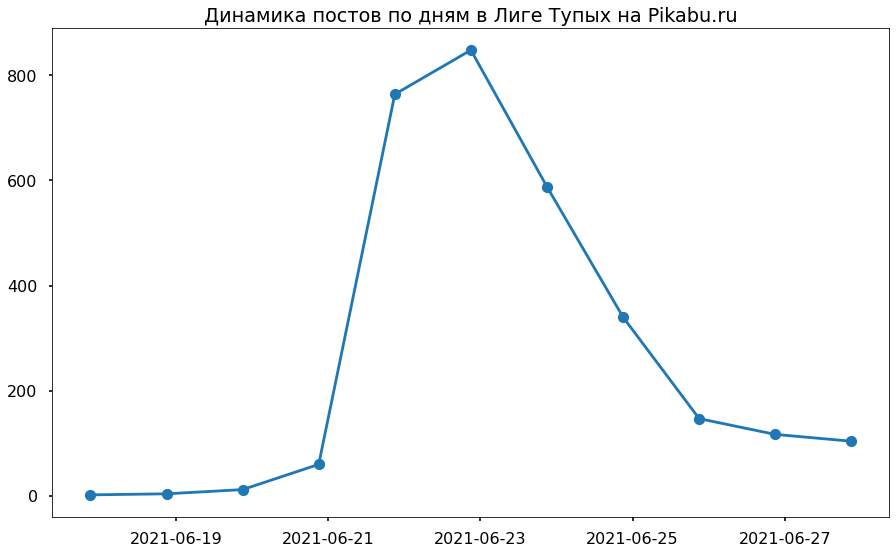

In [14]:
plt.figure(figsize=[15, 9])
plt.title('Динамика постов по дням в Лиге Тупых на Pikabu.ru')
plt.plot(df_by_days['updates'], '-o')
plt.show()

In [15]:
df_by_days.mean()

updates    271.454545
dtype: float64

In [16]:
df_by_days.describe()

,updates
count,11.000000
mean,271.454545
std,316.774167
min,2.000000
25%,36.000000
50%,117.000000
75%,464.000000
max,848.000000


In [17]:
df_by_days_score = df[['date', 'rating']]
df_by_days_score = df_by_days_score.resample('D', convention='end', label='left', on='date').sum()

In [18]:
df_by_days_score.sort_values('rating')

,rating
date,
2021-06-19 00:00:00+03:00,992
2021-06-18 00:00:00+03:00,8334
2021-06-20 00:00:00+03:00,15198
2021-06-28 00:00:00+03:00,16492
2021-06-27 00:00:00+03:00,38576
2021-06-26 00:00:00+03:00,49721
2021-06-25 00:00:00+03:00,103999
2021-06-21 00:00:00+03:00,104842
2021-06-24 00:00:00+03:00,164449


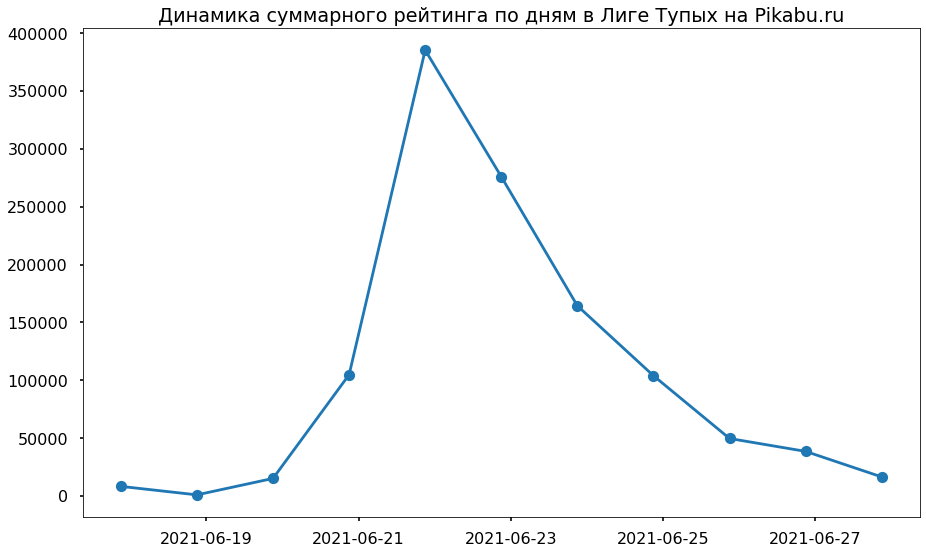

In [19]:
plt.figure(figsize=[15, 9])
plt.title('Динамика суммарного рейтинга по дням в Лиге Тупых на Pikabu.ru')
plt.plot(df_by_days_score['rating'], '-o')
plt.show()

In [20]:
df_top_20 = df[['user', 'rating', 'title']].sort_values('rating', ascending=False).head(20)
df_top_20.columns = ['Имя пользователя', 'Рейтинг поста', 'Заголовок поста']
df_top_20[['Заголовок поста', 'Имя пользователя', 'Рейтинг поста']]

,Заголовок поста,Имя пользователя,Рейтинг поста
2034,Урна наносит ответный удар,JabaPoint,10028
1697,Забытый телефон,A11031978za,9416
1501,Про измену,kvs27,8977
2409,Отсутствующая девятка,durillo,8962
2984,Чо орать то?! Я не повар!,Indianaorc,8314
2805,Когда зашел в горячее сегодня,AlexNightingale,8013
1410,Случай с ДПС,Dante0904,7505
916,Ответ на пост «Бывает»,rita90,7135
2756,Спасибо Лиге Тупых!,stansmith2014,7104
2764,Забавно,MaestroA,7021


In [21]:
df['rating'].mean()

389.85465505693236

In [22]:
df['rating'].describe()

count     2986.000000
mean       389.854655
std        997.017094
min          0.000000
25%          7.000000
50%         16.000000
75%        153.000000
max      10028.000000
Name: rating, dtype: float64

In [23]:
# Null rating
df[df['rating'] == 0].shape[0]/df.shape[0]

0.16577361018084394

In [24]:
# Generate a frequency dictionary
list_tags = []
list_tags_temp = df['tags'].str.split(' (?=[A-ZА-Я])').tolist()
for l in list_tags_temp:
    list_tags.extend(l)
list_tags = np.unique(list_tags, return_counts=True)
dict_tags = {key: value for key, value in zip(list_tags[0], list_tags[1])}
# Delete uninformative words
stop_words = ['Тупость', 'Текст', 'Лига тупых', '[моё]'] 
for word in stop_words:
    dict_tags.pop(word, None)

In [25]:
wc = WordCloud(
    background_color='white',
    max_font_size=400,
    width=1500,
    height=1000,
    max_words=200,
    stopwords = []
)

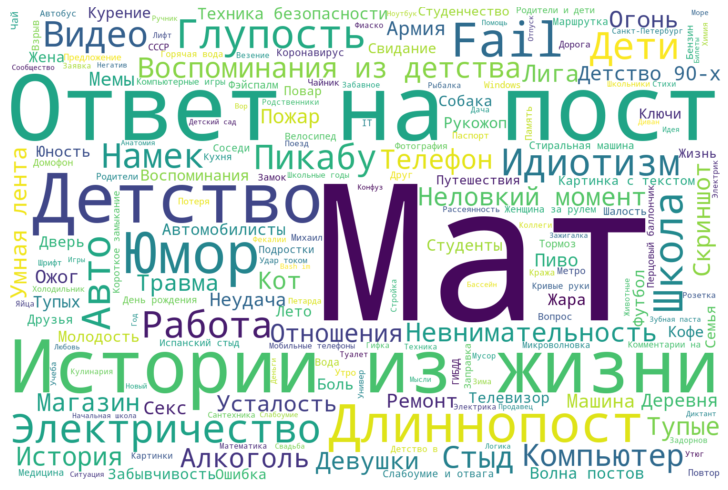

In [26]:
wc.generate_from_frequencies(dict_tags)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

# NLP

In [27]:
# Load pretrained USE-model
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder-multilingual/3') 

In [28]:
# Calculate length of texts
df['content_len'] = df['content'].str.len()

In [29]:
df['content_len'].describe()

count    2986.000000
mean      756.536504
std       603.486430
min         1.000000
25%       344.000000
50%       631.000000
75%       997.000000
max      4205.000000
Name: content_len, dtype: float64

In [30]:
df.shape

(2986, 9)

In [31]:
# Delete texts with length less than 100 symbols
df = df[df['content_len'] > 100]

In [32]:
df.shape

(2744, 9)

In [33]:
df['content_len'].sum()

2250283

In [34]:
# Generate embeddings
nlp = USEEncoder(16, 'content')
embeddings = nlp.transform(df, embed)

100%|██████████| 171/171 [00:18<00:00,  9.09it/s]


In [38]:
embeddings.shape

(2744, 512)

100%|██████████| 75/75 [06:21<00:00,  5.08s/it]


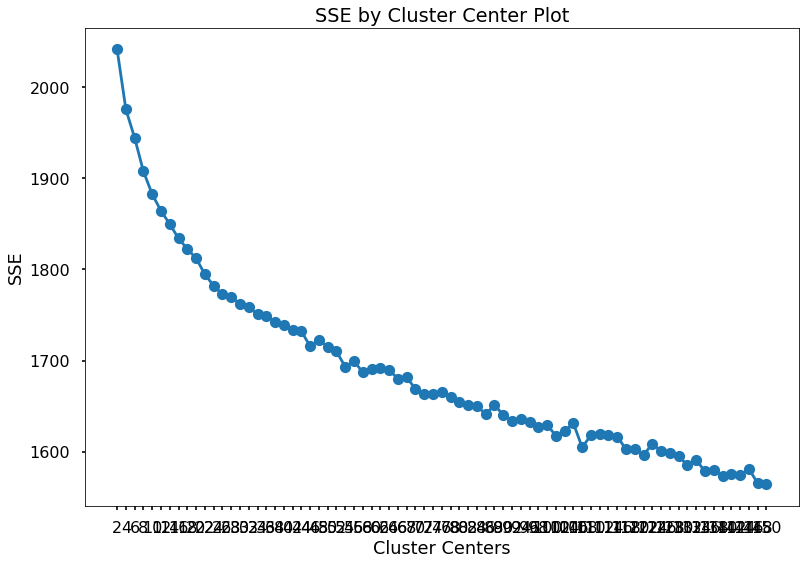

In [36]:
# Calculate optimal number of clusters
calculate_number_clusters(embeddings, 150)

In [37]:
# Added clusters
n_clusts = 12
clusters = clustering(embeddings, n_clusts)
df['clusters'] = clusters

In [38]:
df['clusters'].value_counts()

2     308
10    304
8     287
1     252
7     244
5     239
11    237
9     205
4     202
3     173
0     172
6     121
Name: clusters, dtype: int64

In [39]:
x_umap = umap.UMAP(n_components=2).fit_transform(embeddings)

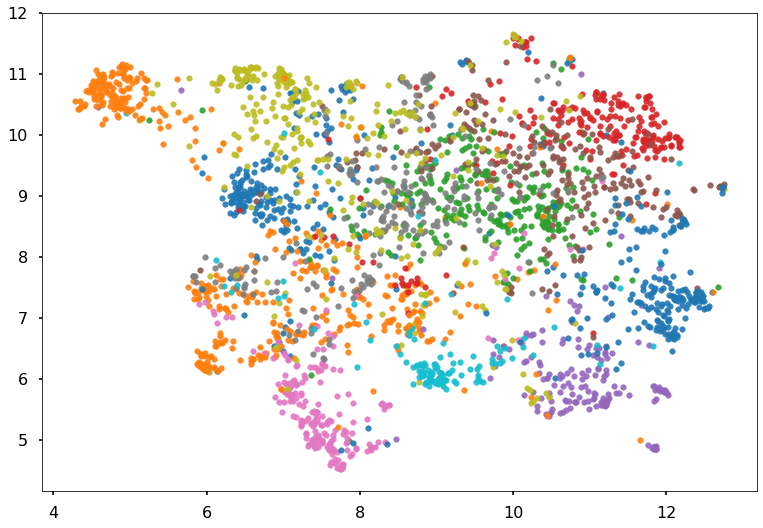

In [40]:
for i in df['clusters'].unique():
    indx = np.where(df['clusters'] == i)
    plt.scatter(x_umap[indx, 0], x_umap[indx, 1], marker='.', alpha=0.9)
plt.show()

In [41]:
x_umap_3d = umap.UMAP(n_components=3).fit_transform(embeddings)

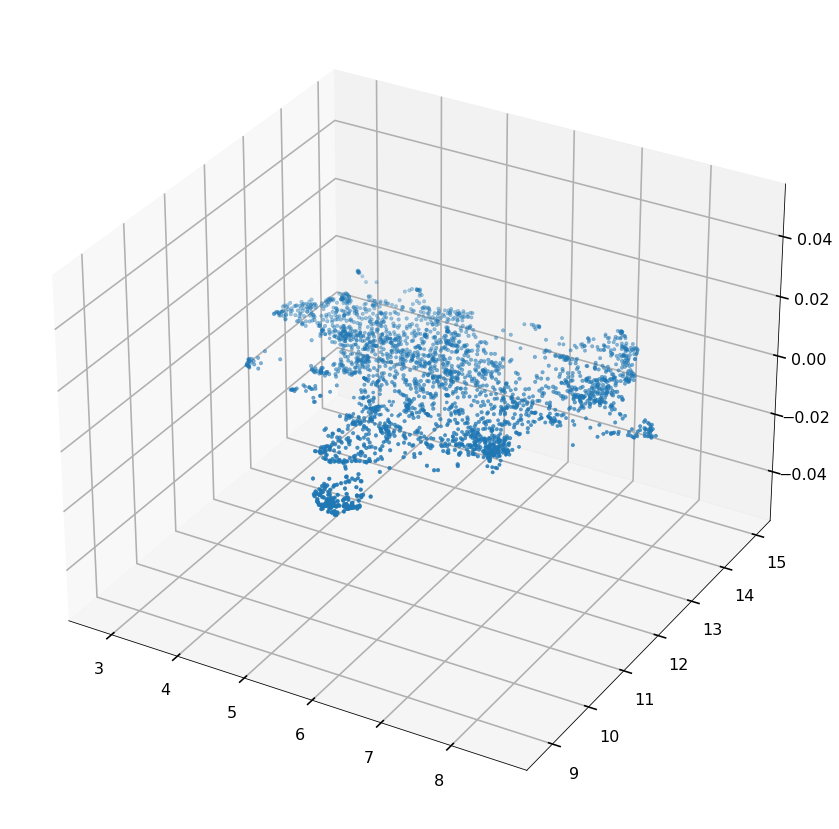

In [42]:
plt.figure(figsize=[15, 15])
plt.subplot(111, projection='3d')
plt.scatter(x_umap_3d[:,2], x_umap_3d[:,0], x_umap_3d[:,1], )
plt.show()